In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# New Section

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11035863343334132319, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8563320921033718909
 physical_device_desc: "device: XLA_CPU device"]

In [ ]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
from random import shuffle
import shutil
import imageio as im

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, initializers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, BatchNormalization, Input, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate

# **Двухклассовая классификация**

In [ ]:
img_width, img_height = 133, 108
if K.image_data_format() == 'channels_first':
  input_shape = (1, img_width, img_height)
else:
  input_shape = (img_width, img_height, 1)

In [ ]:
glorot_normal = initializers.he_normal()

model = Sequential()
model.add(Conv2D(filters=4, activation='relu', strides = (2, 2), kernel_size=(10, 1), kernel_initializer=glorot_normal, input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters=4, activation='relu', strides =(2, 2), kernel_size=(5, 1), kernel_initializer=glorot_normal))
model.add(BatchNormalization())
model.add(Conv2D(filters=4, activation='relu', strides =(2, 2), kernel_size=(1, 1), kernel_initializer=glorot_normal))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, kernel_initializer=glorot_normal, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, kernel_initializer=glorot_normal, activation='relu'))
model.add(Dense(1, kernel_initializer=glorot_normal, activation = 'sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 54, 4)         44        
_________________________________________________________________
batch_normalization_15 (Batc (None, 62, 54, 4)         16        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 27, 4)         84        
_________________________________________________________________
batch_normalization_16 (Batc (None, 29, 27, 4)         16        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 14, 4)         20        
_________________________________________________________________
batch_normalization_17 (Batc (None, 15, 14, 4)         16        
_________________________________________________________________
flatten_5 (Flatten)          (None, 840)              

In [ ]:
adam = optimizers.Adam()
adadelta = optimizers.Adadelta()
nadam = optimizers.Nadam()
sgd = optimizers.SGD()
model.compile(
    loss = 'binary_crossentropy',
    optimizer = nadam,
    metrics = ['accuracy'])

In [ ]:
batch_size = 256
num_classes = 2
main_dir = '/content/drive/-/RADclass'
train_data_dir = main_dir + '/train'
val_data_dir = main_dir + '/val'
test_data_dir = main_dir + '/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
    directory = train_data_dir,
    target_size = (img_width, img_height),
    color_mode = 'grayscale',
    classes = ['point', 'flow'],
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = True
)

validation_data_generator = val_datagen.flow_from_directory(
    directory = val_data_dir,
    target_size = (img_width, img_height),
    color_mode = 'grayscale',
    classes = ['point', 'flow'],
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = True
)

test_data_generator = test_datagen.flow_from_directory(
    directory = test_data_dir,
    target_size = (img_width, img_height),
    color_mode = 'grayscale',
    classes = ['point', 'flow'],
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False
)

Found 2674 images belonging to 2 classes.
Found 572 images belonging to 2 classes.
Found 573 images belonging to 2 classes.


In [ ]:
%%time
nb_train_samples = 2674
nb_val_samples = 573
nb_test_samples = 573
epochs = 50
callbacks = [
             keras.callbacks.ModelCheckpoint("/content/drive/-/RAD.h5", monitor = 'val_accuracy', save_best_only=True, save_weights_only=False, mode='auto'),
             keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)
             ]
history = model.fit_generator(
    train_data_generator,
    steps_per_epoch = nb_train_samples//batch_size,
    epochs = epochs,
    validation_data = validation_data_generator,
    validation_steps = nb_val_samples//batch_size,
    callbacks = callbacks
    )

Epoch 1/50
10/10 [==============================] - 9s 926ms/step - loss: 0.4753 - accuracy: 0.7684 - val_loss: 0.6726 - val_accuracy: 0.5703
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 0.1944 - accuracy: 0.9181 - val_loss: 0.6422 - val_accuracy: 0.6953
Epoch 3/50
10/10 [==============================] - 9s 889ms/step - loss: 0.1284 - accuracy: 0.9446 - val_loss: 0.6233 - val_accuracy: 0.6270
CPU times: user 41.1 s, sys: 1.93 s, total: 43 s
Wall time: 32.8 s


In [ ]:
validation_data_generator.class_indices

{'flow': 1, 'point': 0}

(1, 133, 108, 1)
Predicted class is: [[1]]


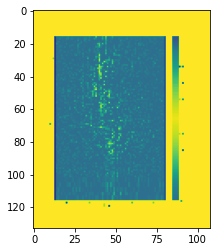

In [ ]:
img_path_1 = f'/content/drive/-\panel05.png'
img_path = img_path_1
img = image.load_img(img_path,color_mode='grayscale', target_size=(img_width, img_height))
#img = img.resize(( img_height, img_width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
#plt.imshow(img)
#plt.show()
print(img_tensor.shape)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict_classes(images)
print("Predicted class is:",classes)

In [ ]:
y_pred = []
y_true = []

In [ ]:
img_path_1 = f'/content/drive/-/modeling/RADclass/test/point/5.png'
tr = 0
fl = 0
for i in np.arange(0, 285):
  img_path_1 = f'/content/drive/-/modeling/RADclass/test/point/{i}.png'
  img_path = img_path_1
  img = image.load_img(img_path,color_mode='grayscale', target_size=(img_width, img_height))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  #plt.imshow(img_tensor[0])
  #plt.show()
  #print(img_tensor.shape)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict_classes(images)
  #print("Predicted class is:",classes)
  y_pred.append(classes[0][0])
  y_true.append(0)
  if classes[0][0] == 0:
    tr+=1
  else:
    fl += 1

In [ ]:
img_path_2 = f'/content/drive/-/modeling/RADclass/test/flow/5.png'
tr_fl = 0
fl_fl = 0
for i in np.arange(0, 285):
  img_path_1 = f'/content/drive/-/modeling/RADclass/test/flow/{i}.png'
  img_path = img_path_1
  img = image.load_img(img_path,color_mode='grayscale', target_size=(img_width, img_height))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  #plt.imshow(img_tensor[0])
  #plt.show()
  #print(img_tensor.shape)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict_classes(images)
  #print("Predicted class is:",classes)
  y_pred.append(classes[0][0])
  y_true.append(1)
  if classes[0][0] == 1:
    tr_fl += 1
  else:
    fl_fl += 1

In [ ]:
print(tr_fl, fl_fl)

256 29


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

Confusion Matrix
[[264  21]
 [ 29 256]]


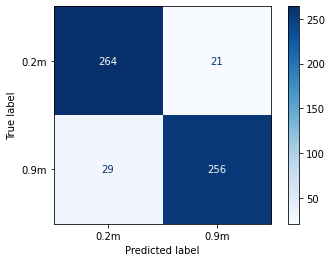

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp  = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['0.2m', '0.9m'] )
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/-/Models/RAD 03052020 2 07.h5')

# **Мультиклассовая классификация**

In [ ]:
img_width, img_height = 133, 108
if K.image_data_format() == 'channels_first':
  input_shape = (1, img_width, img_height)
else:
  input_shape = (img_width, img_height, 1)

In [ ]:
glorot_normal = initializers.he_normal()

def naive_inception_module(layer_in):

  conv3_1 = Conv2D(filters = 16,kernel_size=(7, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(layer_in)
  conv3_2 = Conv2D(filters = 8, kernel_size=(5, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv3_1)
  conv3_3 = Conv2D(filters = 4, kernel_size=(2, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv3_2)
  
  conv4_1 = Conv2D(filters = 32,kernel_size=(7, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(layer_in)
  conv4_2 = Conv2D(filters = 16, kernel_size=(5, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv4_1)
  conv4_3 = Conv2D(filters = 8, kernel_size=(2, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv4_2)

  conv5_1 = Conv2D(filters = 4,kernel_size=(7, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(layer_in)
  conv5_2 = Conv2D(filters = 4, kernel_size=(5, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv5_1)
  conv5_3 = Conv2D(filters = 4, kernel_size=(2, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv5_2)

  conv6_1 = Conv2D(filters = 2, kernel_size=(3, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(layer_in)
  conv6_2 = Conv2D(filters = 2, kernel_size=(3, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv6_1)
  conv6_3 = Conv2D(filters = 2, kernel_size=(3, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv6_2)

  conv7_1 = Conv2D(filters = 8, kernel_size=(10, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(layer_in)
  conv7_2 = Conv2D(filters = 8, kernel_size=(7, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv7_1)
  conv7_3 = Conv2D(filters = 8, kernel_size=(5, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv7_2)
  
  layer_out = concatenate([conv3_3, conv4_3, conv5_3, conv6_3, conv7_3], axis=-1)
  return layer_out
 

visible = Input(shape=input_shape)
layer = naive_inception_module(visible)

flatten = Flatten()(layer)
dense1 = Dense(512, kernel_initializer=glorot_normal, activation='relu')(flatten)
drop1 = Dropout(0.25)(dense1)
dense2 = Dense(256, kernel_initializer=glorot_normal, activation='relu')(drop1)
dense3 = Dense(8, kernel_initializer=glorot_normal, activation = 'softmax')(dense2)

model = Model(inputs=visible, outputs=dense3)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 133, 108, 1) 0                                            
__________________________________________________________________________________________________
conv2d_138 (Conv2D)             (None, 67, 54, 16)   128         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 67, 54, 32)   256         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 67, 54, 4)    32          input_9[0][0]                    
____________________________________________________________________________________________

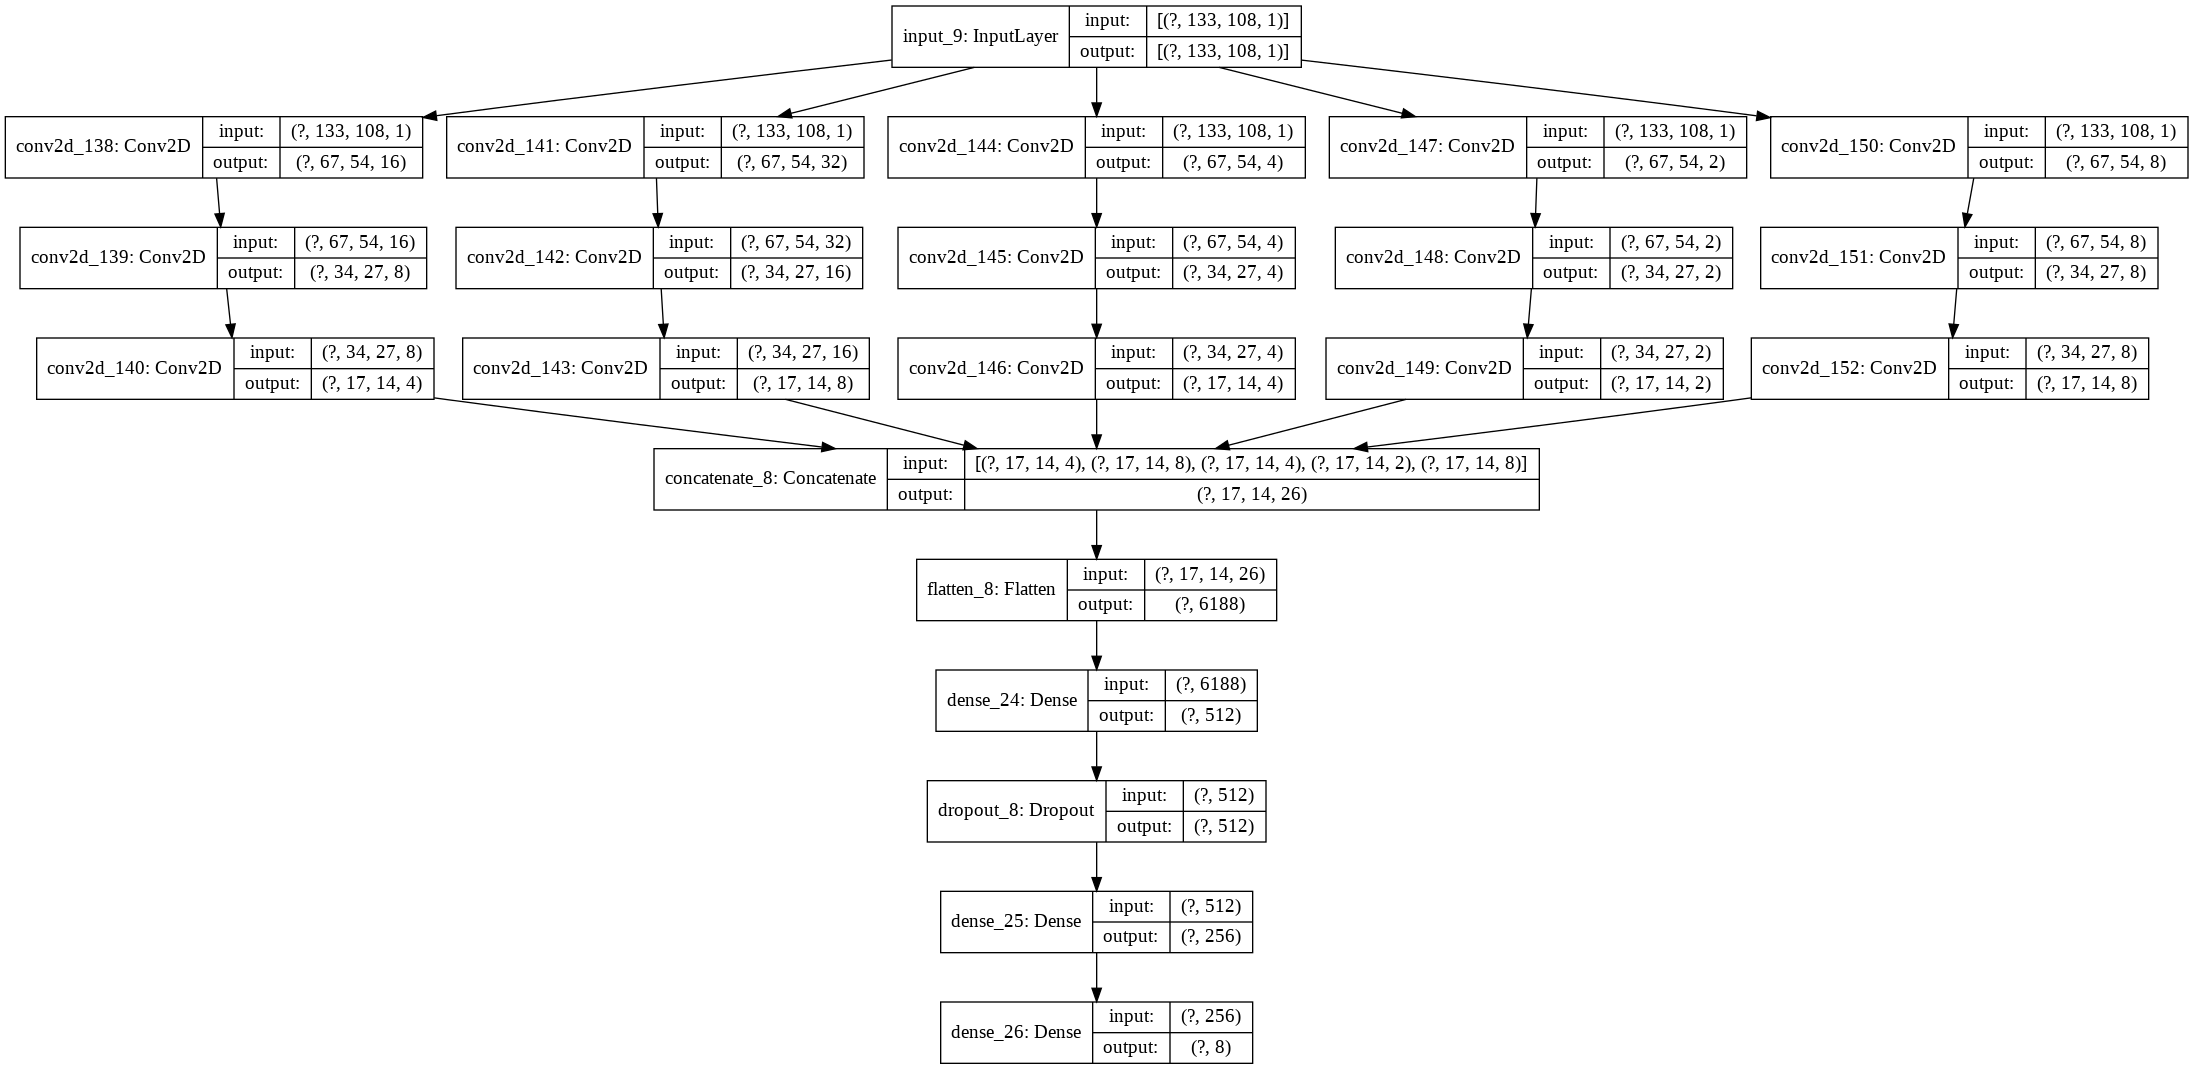

In [ ]:
plot_model(model, show_shapes=True, to_file='/content/drive/-/naive_inception_module.png')

In [ ]:
adam = optimizers.Adam()
adadelta = optimizers.Adadelta()
nadam = optimizers.Nadam()
sgd = optimizers.SGD()
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = nadam,
    metrics = ['accuracy'])

In [ ]:
batch_size = 256
main_dir = '/content/drive/-/modeling/RADMulticlass'
train_data_dir = main_dir + '/train'
val_data_dir = main_dir + '/val'
test_data_dir = main_dir + '/test'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,
                                 vertical_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  vertical_flip = True)

train_data_generator = train_datagen.flow_from_directory(
    directory = train_data_dir,
    target_size = (img_width, img_height),
    color_mode = 'grayscale',
    classes = ['rad2', 'rad3','rad4', 'rad5', 'rad6', 'rad7', 'rad8', 'rad9'],
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True
)

validation_data_generator = val_datagen.flow_from_directory(
    directory = val_data_dir,
    target_size = (img_width, img_height),
    color_mode = 'grayscale',
    classes = ['rad2', 'rad3', 'rad4', 'rad5', 'rad6', 'rad7', 'rad8', 'rad9'],
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True
)


Found 10757 images belonging to 8 classes.
Found 2302 images belonging to 8 classes.


In [ ]:
%%time
nb_train_samples = 10757
nb_val_samples = 2302
epochs = 50
callbacks = [
             keras.callbacks.ModelCheckpoint("/content/drive/-/RAD.h5", monitor = 'val_accuracy', save_best_only=True, save_weights_only=False, mode='auto'),
             keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)
             ]
history = model.fit_generator(
    train_data_generator,
    steps_per_epoch = nb_train_samples//batch_size,
    epochs = epochs,
    validation_data = validation_data_generator,
    validation_steps = nb_val_samples//batch_size,
    callbacks = callbacks
    )

Epoch 1/50
42/42 [==============================] - 103s 2s/step - loss: 2.2281 - accuracy: 0.1629 - val_loss: 1.9309 - val_accuracy: 0.1943
Epoch 2/50
42/42 [==============================] - 106s 3s/step - loss: 1.7171 - accuracy: 0.3147 - val_loss: 1.2885 - val_accuracy: 0.5107
Epoch 3/50
42/42 [==============================] - 102s 2s/step - loss: 1.2467 - accuracy: 0.4964 - val_loss: 0.9980 - val_accuracy: 0.5889
Epoch 4/50
42/42 [==============================] - 102s 2s/step - loss: 0.9611 - accuracy: 0.6050 - val_loss: 0.8034 - val_accuracy: 0.6802
Epoch 5/50
42/42 [==============================] - 101s 2s/step - loss: 0.8764 - accuracy: 0.6406 - val_loss: 0.7726 - val_accuracy: 0.6807
Epoch 6/50
42/42 [==============================] - 102s 2s/step - loss: 0.8565 - accuracy: 0.6542 - val_loss: 0.6816 - val_accuracy: 0.7197
Epoch 7/50
42/42 [==============================] - 101s 2s/step - loss: 0.8032 - accuracy: 0.6730 - val_loss: 0.6900 - val_accuracy: 0.7095
CPU times: us

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/-/RAD.h5')

In [ ]:
y_pred = []
y_true = []

In [ ]:
rad2 = '/content/drive/-/modeling/RADMulticlass/test/rad2'
rad2_list = []
for root, dirs, files in os.walk("/content/drive/-/modeling/RADMulticlass/test/rad2"):
    for file in files:
        if file.endswith(".png"):
            rad2_list.append(os.path.join(root, file))
for img in rad2_list:
  img_path = img
  img = image.load_img(img_path,color_mode='grayscale', target_size=(img_width, img_height))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images)
  y_pred.append(classes.argmax())
  y_true.append(0)

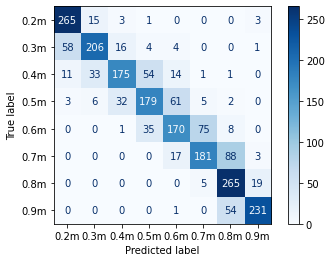

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp  = ConfusionMatrixDisplay(confusion_matrix(np.array(y_true, dtype=int), np.array(y_pred, dtype = int)), display_labels=['0.2m', '0.3m', '0.4m', '0.5m', '0.6m', '0.7m', '0.8m', '0.9m'] )
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()